# #1: create an environment and select the kernel
Here are the command I use for creating an env:

`conda create --name MotorSavings python=3.10`

Once you done that make sure that your notebook is connected to your env. You may need to close and reopen your program.
# Install all required packages
`pip install -r ../requirements.txt`

In [1]:
!pip install -r ../requirements.txt

# 1- Train the models

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_loss
from plot import plot_learning
import matplotlib.pyplot as plt
from utils import get_initial_loss, get_rate
import pandas as pd
import seaborn as sb



#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [2]:
folder_name = 'Sim_fixed_128'
n_model = 40 # number of simulated networks
sizes = [16,32,64,128,256]

# Running all models for all phases of training and for different network sizes
This could take almost one day, depending on your system. 
### Skip this if you already have your networks  

In [8]:
for n_s in sizes: # sizes
    network_siz = n_s
    !python ../model.py {1} {network_siz} {n_model} {0} {1}

model00...model01...

Training growing_up:  40%|████████            | 4/10 [00:09<00:13,  2.28s/batch]Batch 4/10 Done, mean position loss: 116.10464584827423
Batch 4/10 Done, mean position loss: 121.01237058639526
Training growing_up:  80%|████████████████    | 8/10 [00:18<00:04,  2.39s/batch]Batch 8/10 Done, mean position loss: 104.5529465675354
Batch 8/10 Done, mean position loss: 118.0314508676529
Training growing_up: 100%|███████████████████| 10/10 [00:24<00:00,  2.45s/batch]
Done...
Training growing_up: 100%|███████████████████| 10/10 [00:24<00:00,  2.46s/batch]
Done...
model00...
model01...
Training NF1: 100%|██████████████████████████| 10/10 [00:27<00:00,  2.75s/batch]
Done...
Training NF1: 100%|██████████████████████████| 10/10 [00:27<00:00,  2.76s/batch]
Done...
model00...
model01...
Training FF1: 100%|██████████████████████████| 10/10 [00:26<00:00,  2.64s/batch]
Done...
Training FF1: 100%|██████████████████████████| 10/10 [00:26<00:00,  2.65s/batch]
Done...
model00...
model01

# General things

You can specify a saving directory, basically the directory in which the figure can be saved.
The base directory is **hard-coded** in the current version of the code.


In [3]:
loss_type = 'lateral' # I chose lateral deviation as the loss function


phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}


fontsize_label = 8
fontsize_tick = 8
fontsize_legend = 8

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = '/Users/mahdiyar/Dropbox (Personal)/MotorSavings/paper/figures_raw'
if not os.path.exists(save_fig):
    save_fig = os.getcwd()  # Set current directory as save_dir if save_dir doesn't exist

# #1: Learing curves for all phases

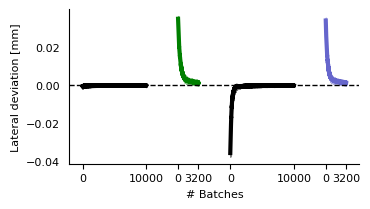

In [4]:
ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
loss = get_loss(folder_name,n_model,phases,loss_type=loss_type,w=1,target=None,ignore=ignore)

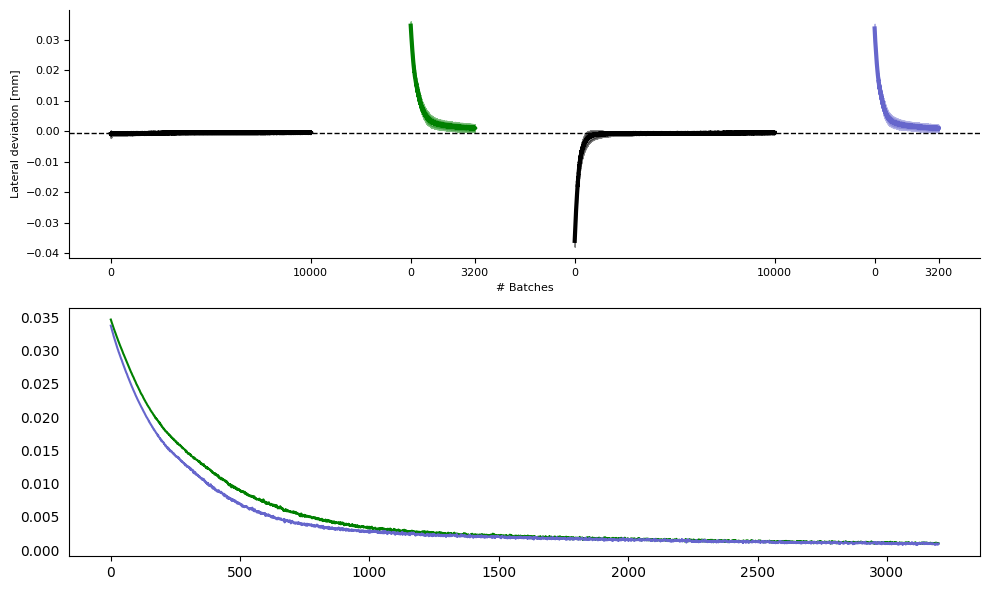

In [11]:
# Plot learning

fig, ax = plot_learning(loss,figsize=(10,6),show_saving=True,gap=5000,palette_colors=palette_colors) # (3.8,2.2)


ax[0].set_xlabel('# Batches', fontsize = fontsize_label)
ax[0].set_ylabel('Lateral deviation [mm]', fontsize = fontsize_label)
ax[0].legend(title = '',frameon = False, bbox_to_anchor= (1,1), fontsize=fontsize_legend)
ax[0].legend().set_visible(False)
ax[0].xaxis.set_tick_params(labelsize=fontsize_tick)
ax[0].yaxis.set_tick_params(labelsize=fontsize_tick)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
plt.tick_params(left = False) 

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(save_fig,'learning_curve2.pdf'),dpi=300,bbox_inches='tight')

# #2: Do we have savings? 
Get the initial values of the loss and also the learning rate. It saves the result as a dataframe so that we don't need to run it every time.

In [12]:
# Create the dataframe
D = pd.DataFrame()

for n_s in sizes:
    network_siz = n_s
    fn = f'Sim_fixed_{network_siz}'

    ignore = return_ignore(fn,n_model)
    loss = get_loss(fn,n_model,phases,loss_type=loss_type,w=1,target=None,ignore=ignore)

    R = get_rate(loss,w=5,check_fit=False)
    I = get_initial_loss(loss)

    R['size'] = network_siz
    I['size'] = network_siz

    T = pd.concat([R,I], ignore_index=True)

    D = pd.concat([D,T], ignore_index=True)

D.to_csv(base_dir+'/model_loss.csv',index=False)

# Plot the result only for network of size 128

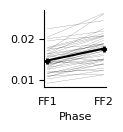

In [24]:
# Generate the plots
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'rate' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1', 'FF2'])) &
    (D['size'] == 128) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)

# plot 
fig, ax = plt.subplots(1, 1, figsize=(0.8,1))

for id, data in T.groupby('mn'):
    ff1_value = data[data['phase'] == 'FF1']['value'].values[0]
    ff2_value = data[data['phase'] == 'FF2']['value'].values[0]
    ax.plot(['FF1', 'FF2'], [ff1_value, ff2_value], color='k',linewidth=0.1)
    
#sb.barplot(x='phase', y='value', data=T, hue='phase', width=0.5, ax=ax, palette=palette_colors,errorbar=None)
mean_ff1 = T[T['phase'] == 'FF1']['value'].mean()
mean_ff2 = T[T['phase'] == 'FF2']['value'].mean()
p1='FF1'
p2='FF2'
# Plotting line connecting the means
ax.plot([p1, p2], [mean_ff1, mean_ff2], color='k', linewidth=1.5)

# Adding "+" marker at the means
ax.plot(p1, mean_ff1, marker='+', color='k', markersize=5, mew=2)
ax.plot(p2, mean_ff2, marker='+', color='k', markersize=5, mew=2)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom=False)
ax.set_xlabel('Phase', fontsize=fontsize_label)

if feature == 'rate':
    #ax.set_ylabel('Learning rate [1/batch]', fontsize=fontsize_label)
    #ax.set_ylim([0,0.0005])
    fig.savefig(os.path.join(save_fig, 'saving_rate.pdf'), dpi=300, bbox_inches='tight')
else:
    #ax.set_ylabel('Initial lateral deviation [mm]', fontsize=fontsize_label)
    #ax.set_ylim([0.02,0.04])
    fig.savefig(os.path.join(save_fig, 'saving_init.pdf'), dpi=300, bbox_inches='tight')



# Plot the result only for networks of all sizes

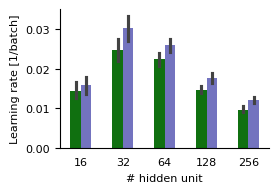

In [59]:
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'rate' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1', 'FF2'])) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)


fig, ax = plt.subplots(1, 1, figsize=(2.7, 1.8))
sb.barplot(x='size', y='value', data=T, hue='phase', width=0.5, ax=ax, palette=palette_colors) # ,errorbar=None


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom=False)
ax.set_xlabel('# hidden unit', fontsize=fontsize_label)
ax.legend().set_visible(False)

if feature =='init':
    ax.set_ylabel('Initial lateral deviation [mm]', fontsize=fontsize_label)
    fig.savefig(os.path.join(save_fig, 'saving_all_init.pdf'), dpi=300, bbox_inches='tight')
else:
    ax.set_ylabel('Learning rate [1/batch]', fontsize=fontsize_label)
    fig.savefig(os.path.join(save_fig, 'saving_all_rate.pdf'), dpi=300, bbox_inches='tight')


#fig.savefig(os.path.join(save_fig, 'perf_vs_size.pdf'), dpi=300, bbox_inches='tight')

# % of network that showed saving vs. network size

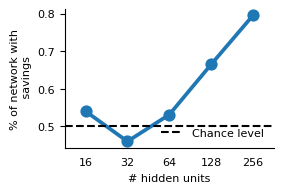

In [58]:
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'init' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1','FF2'])) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)

ff1_data = T[T['phase']=='FF1']
ff2_data = T[T['phase']=='FF2']

merged_data = pd.merge(ff1_data,ff2_data,on='size',suffixes=('_ff1', '_ff2'))

# Calculate the difference in 'loss'
if feature == 'init':
    merged_data['loss_difference'] = (merged_data['value_ff2']-merged_data['value_ff1']<0) 
else:
    merged_data['loss_difference'] = (merged_data['value_ff2']-merged_data['value_ff1']>0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(2.7, 1.8))
sb.pointplot(x='size', y='loss_difference', data=merged_data, ax=ax,errorbar=None) #,errorbar=None
ax.axhline(0.5, color='black', linestyle='--', label='Chance level')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('# hidden units', fontsize = fontsize_label)
ax.set_ylabel('% of network with\n savings', fontsize = fontsize_label)

ax.legend(fontsize=fontsize_legend,loc='lower right',frameon = False)

if feature == 'init':
    fig.savefig(os.path.join(save_fig,'percent_init.pdf'),dpi=300,bbox_inches='tight')
else:
    fig.savefig(os.path.join(save_fig,'percent_rate.pdf'),dpi=300,bbox_inches='tight')

#fig.savefig(os.path.join(save_fig,'saving_vs_size.pdf'),dpi=300,bbox_inches='tight')